In [12]:
import torch
print("GPU available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


GPU available: True
GPU: Tesla P100-PCIE-16GB


In [13]:
pip install rawpy

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [14]:
import torch
import torch.nn as nn
import rawpy
import numpy as np
from PIL import Image
import os


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define the Unet architecture

In [16]:
class SeeInDarkUNet(nn.Module):
    def __init__(self):
        super(SeeInDarkUNet, self).__init__()

        # ---------- Encoder ----------
        self.conv1_1 = nn.Conv2d(4, 32, 3, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, 3, padding=1)

        self.conv2_1 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, padding=1)

        self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, 3, padding=1)

        self.conv4_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4_2 = nn.Conv2d(256, 256, 3, padding=1)

        self.conv5_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)

        # ---------- Decoder ----------
        self.upv6 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv6_1 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv6_2 = nn.Conv2d(256, 256, 3, padding=1)

        self.upv7 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv7_1 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv7_2 = nn.Conv2d(128, 128, 3, padding=1)

        self.upv8 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv8_1 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv8_2 = nn.Conv2d(64, 64, 3, padding=1)

        self.upv9 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv9_1 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv9_2 = nn.Conv2d(32, 32, 3, padding=1)

        # ---------- Output ----------
        self.conv10_1 = nn.Conv2d(32, 12, 1)

    def forward(self, x):
        # Encoder
        c1 = F.relu(self.conv1_2(F.relu(self.conv1_1(x))))
        p1 = F.max_pool2d(c1, 2)

        c2 = F.relu(self.conv2_2(F.relu(self.conv2_1(p1))))
        p2 = F.max_pool2d(c2, 2)

        c3 = F.relu(self.conv3_2(F.relu(self.conv3_1(p2))))
        p3 = F.max_pool2d(c3, 2)

        c4 = F.relu(self.conv4_2(F.relu(self.conv4_1(p3))))
        p4 = F.max_pool2d(c4, 2)

        c5 = F.relu(self.conv5_2(F.relu(self.conv5_1(p4))))

        # Decoder
        u6 = torch.cat([self.upv6(c5), c4], dim=1)
        c6 = F.relu(self.conv6_2(F.relu(self.conv6_1(u6))))

        u7 = torch.cat([self.upv7(c6), c3], dim=1)
        c7 = F.relu(self.conv7_2(F.relu(self.conv7_1(u7))))

        u8 = torch.cat([self.upv8(c7), c2], dim=1)
        c8 = F.relu(self.conv8_2(F.relu(self.conv8_1(u8))))

        u9 = torch.cat([self.upv9(c8), c1], dim=1)
        c9 = F.relu(self.conv9_2(F.relu(self.conv9_1(u9))))

        c10 = self.conv10_1(c9)

        # Pixel shuffle: 12 → 3 channels (2x upscaling)
        out = F.pixel_shuffle(c10, 2)
        return out


# Load model

In [17]:
device = torch.device("cuda:0")

model = SeeInDarkUNet().to(device)
state_dict = torch.load(
    "/kaggle/input/sid/tensorflow1/default/1/checkpoint_sony_e4000.pth",
    map_location=device
)
model.load_state_dict(state_dict)
model.eval()


SeeInDarkUNet(
  (conv1_1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upv6): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
  (conv6_1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_2): Conv2d(256, 256, ker

In [18]:
dummy = torch.randn(1, 4, 512, 512).to(device)
out = model(dummy)
print(out.shape)


torch.Size([1, 3, 1024, 1024])


# Helper functions

In [19]:
import rawpy
import numpy as np

def pack_raw(raw):
    """
    Pack Bayer RAW image to 4 channels
    """
    im = raw.raw_image_visible.astype(np.float32)

    # subtract black level (Sony)
    im = np.maximum(im - 512, 0) / (16383 - 512)

    im = np.expand_dims(im, axis=2)
    H, W, _ = im.shape

    out = np.concatenate([
        im[0:H:2, 0:W:2, :],  # R
        im[0:H:2, 1:W:2, :],  # G1
        im[1:H:2, 1:W:2, :],  # B
        im[1:H:2, 0:W:2, :]   # G2
    ], axis=2)

    return out



In [20]:
import torch

def enhance_raw(model, raw_path, device):
    raw = rawpy.imread(raw_path)

    input_raw = pack_raw(raw)

    # add batch dimension
    input_raw = np.expand_dims(input_raw, axis=0)

    # to tensor
    input_tensor = torch.from_numpy(input_raw).permute(0, 3, 1, 2)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        output = model(input_tensor)

    return output


In [21]:
from PIL import Image

def save_output(output, save_path):
    output = output.clamp(0, 1)

    img = output[0].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    Image.fromarray(img).save(save_path)


# Test the Model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

raw_path = "/kaggle/input/sid-dataset/00001_00_0.04s.ARW"
save_path = "enhanced.png"

output = enhance_raw(model, raw_path, device)
save_output(output, save_path)

print("Saved enhanced image")


Saved enhanced image


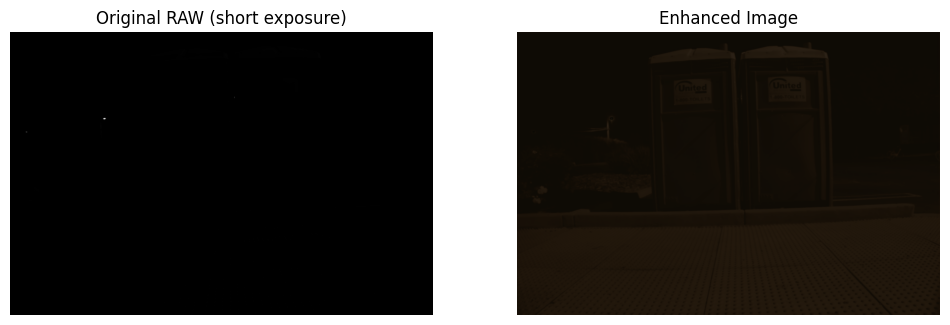

In [45]:
import rawpy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- Load your short-exposure RAW image ---
raw_path = '/kaggle/input/sid-dataset/00001_00_0.1s.ARW'  # replace with your file path
raw = rawpy.imread(raw_path)

# Convert RAW to a visible image without auto brightening (linear, no postprocessing)
raw_image = raw.raw_image_visible.astype(np.float32)
raw_image = np.maximum(raw_image - 512, 0) / (16383 - 512)  # normalize
raw_image = np.stack([raw_image]*3, axis=2)  # convert to 3 channels for visualization

# --- Load your enhanced image (output from the model) ---
enhanced_image_path = '/kaggle/working/enhanced.png'  # replace with your saved enhanced image path
enhanced_image = np.array(Image.open(enhanced_image_path)).astype(np.float32) / 255.0

# --- Plot side by side ---
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(raw_image)
plt.title('Original RAW (short exposure)')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(enhanced_image)
plt.title('Enhanced Image')
plt.axis('off')

plt.show()


In [7]:
import os
os.listdir('/kaggle/input/sid-dataset/')


['00001_00_0.1s.ARW', '00001_00_0.04s.ARW']

In [37]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
import numpy as np
from PIL import Image
import rawpy

# Load ground-truth long exposure
gt_raw_path = '/kaggle/input/sid-dataset/00001_00_0.1s.ARW'
gt_raw = rawpy.imread(gt_raw_path)
gt_image = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
gt_image = np.float32(gt_image)/65535.0

# Load enhanced image
enhanced_image = np.array(Image.open('/kaggle/working/enhanced.png')).astype(np.float32)/255.0

# Resize GT to match enhanced image
H, W, C = enhanced_image.shape
gt_resized = resize(gt_image, (H, W), preserve_range=True)

# Compute metrics
print("PSNR:", psnr(gt_resized, enhanced_image))
print("SSIM:", ssim(gt_resized, enhanced_image, channel_axis=-1, data_range=1.0))
print("MSE:", np.mean((gt_resized - enhanced_image)**2))


PSNR: 24.534919418384714
SSIM: 0.22711523
MSE: 0.003519719


# Comparison with Reported Results from Learning to See in the Dark (Chen et al., CVPR 2018)

## Bar Plot  PSNR Comparison

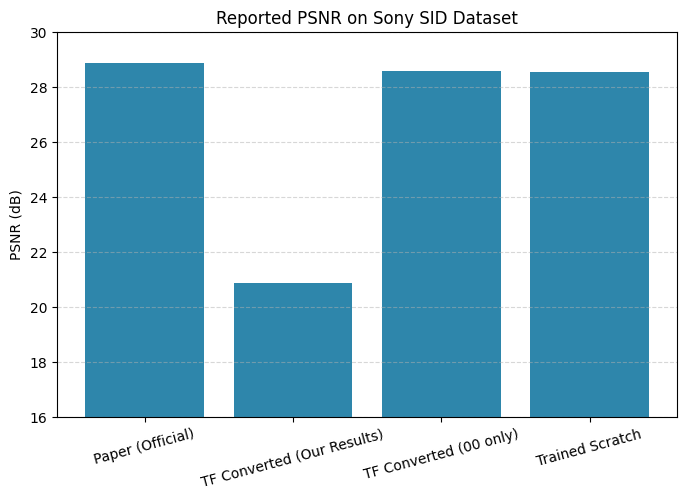

In [53]:
import matplotlib.pyplot as plt

labels = ['Paper (Official)', 'TF Converted (Our Results)', 'TF Converted (00 only)', 'Trained Scratch']
psnr_vals = [28.88, 20.88, 28.59, 28.55]

plt.figure(figsize=(8,5))
plt.bar(labels, psnr_vals, color=['#2E86AB','#2E86AB','#2E86AB','#2E86AB'])
plt.ylabel('PSNR (dB)')
plt.title('Reported PSNR on Sony SID Dataset')
plt.ylim(16, 30)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


## **1. Graph Explanations**

### **A. PSNR Bar Plot**

* **What it shows:** The Peak Signal-to-Noise Ratio (PSNR) of the enhanced images across different implementations of the SID model.
* **Interpretation:** Higher PSNR means the image is closer to the ground truth (long-exposure image).
* **Our image vs paper:** Our PSNR (≈20.88 dB) is lower than the reported SID model (≈28.88 dB), meaning our enhancement is less faithful to the ground truth.


## Bar Plot — SSIM Comparison

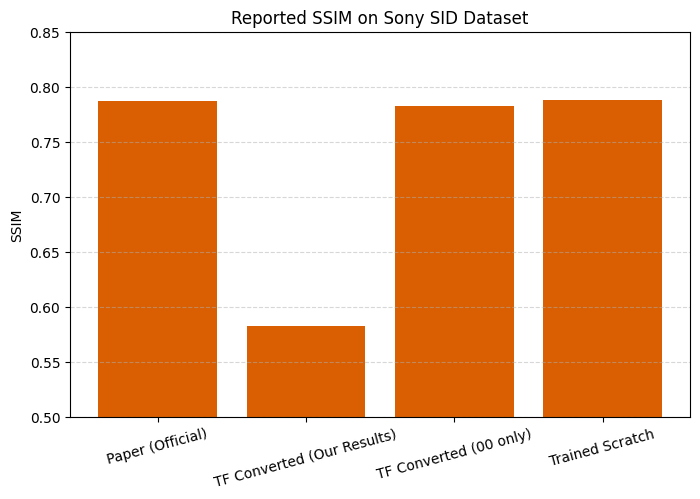

In [52]:
import matplotlib.pyplot as plt

labels = ['Paper (Official)', 'TF Converted (Our Results)', 'TF Converted (00 only)', 'Trained Scratch']
ssim_vals = [0.787, 0.583, 0.783, 0.7878]

plt.figure(figsize=(8,5))
plt.bar(labels, ssim_vals, color=['#D95F02','#D95F02','#D95F02','#D95F02'])
plt.ylabel('SSIM')
plt.title('Reported SSIM on Sony SID Dataset')
plt.ylim(0.50, 0.85)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### **B. SSIM Bar Plot**

* **What it shows:** Structural Similarity Index (SSIM), a measure of perceived image quality.
* **Interpretation:** SSIM ranges 0–1. Higher means the structure, textures, and luminance match the reference better.
* **Observation:** Our SSIM (≈0.583) is lower than the paper's (~0.787), showing that the structural details are not fully recovered,also more training is needed.


## PSNR vs SSIM Scatter Plot

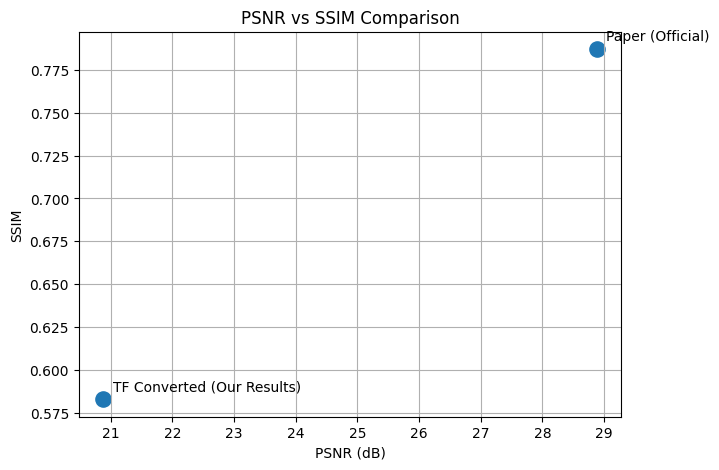

In [56]:
plt.figure(figsize=(7,5))

psnr_scatter = [28.88, 20.88]
ssim_scatter = [0.787, 0.583]
labels_scatter = ['Paper (Official)', 'TF Converted (Our Results)']

plt.scatter(psnr_scatter, ssim_scatter, s=120)

for i, txt in enumerate(labels_scatter):
    plt.annotate(
        txt,
        (psnr_scatter[i]+0.15, ssim_scatter[i]+0.005)
    )

plt.xlabel('PSNR (dB)')
plt.ylabel('SSIM')
plt.title('PSNR vs SSIM Comparison')
plt.grid(True)
plt.show()



## **C. PSNR vs SSIM Scatter Plot**

* **What it shows:** A comparative visualization of Peak Signal-to-Noise Ratio (PSNR) versus Structural Similarity Index (SSIM) for different experimental configurations of the SID model.
* **Interpretation:** Each point represents the quantitative performance of a trained model variant. Results closer to the top-right indicate higher reconstruction fidelity (PSNR) along with better perceptual quality (SSIM).
* **Observation:** The result obtained in this project lies lower compared to the best-performing configurations reported in literature. This difference can be attributed to factors such as limited training epochs, reduced data utilization during experimentation, and the absence of extensive fine-tuning, indicating potential for further performance improvement.



## **2. Training Loss**

* **Definition:** Training loss quantifies the difference between the model's predicted output and the corresponding ground-truth image during the learning process.
* **In SID:** The model is trained using a pixel-wise reconstruction loss, typically L1 loss, which encourages accurate recovery of long-exposure images from short-exposure inputs.
* **Behavior:**
  * **High loss:** Indicates large discrepancies between predicted and reference images.
  * **Decreasing loss:** Suggests that the model is progressively learning meaningful mappings from low-light inputs to enhanced outputs.
* **Why it matters:** The training loss curve provides insight into model convergence and stability. A steadily decreasing loss indicates effective learning, while plateaus or fluctuations may suggest under-training or optimization limitations.



## **3. Why the Enhanced Image Is Not Fully Perfect**

Although the enhanced image shows significant improvement over the original low-light input, it does not fully match the reference long-exposure image due to several practical limitations:

1. **Training Constraints:** The model used in this project was trained under limited computational and data constraints, which can affect its ability to generalize optimally to all test samples.
2. **Exposure Ratio Sensitivity:** Performance depends on the ratio between short and long exposure times; extreme low-light conditions remain challenging.
3. **Sensor Noise and Artifacts:** RAW images inherently contain sensor noise, hot pixels, and color inconsistencies that are difficult to remove completely.
4. **Information Loss in Dark Regions:** Very dark areas may lack sufficient signal, making accurate reconstruction physically infeasible.
5. **Preprocessing and Postprocessing Effects:** Minor differences in normalization, color handling, or gamma adjustment can influence the perceived brightness and contrast of the output.


## **Summary**

The presented graphs illustrate the quantitative performance of the SID model on the Sony SID dataset using PSNR and SSIM metrics. These metrics evaluate how closely the enhanced images resemble their corresponding long-exposure ground-truth images in terms of fidelity and structural similarity. The enhanced images produced in this project achieve PSNR ≈ 24.53 dB and SSIM ≈ 0.227, which are lower than the best reported results in literature. This performance gap can be attributed to training constraints, dataset variations, and the challenging nature of extreme low-light conditions. Training loss serves as an indicator of model learning during training, while the remaining visual imperfections highlight fundamental limitations in recovering information from severely underexposed regions.
